# Boundary hunting with a gated perceptron

Marcus + Stephen conversation thoughts, and a Marcus=simple test version. Stephen : feel free to edit.


### simple perceptron recap / setup
Input patterns $x$ being mapped to output classes $t$.

For a given $x$ pattern in dataset $\mathcal{D} = \{X,T\}$, logistic regression (ie. a regular perceptron having weights and bias $w$) would output the probability of class 1 as $y = \sigma(\phi)$ where $\sigma$ is the sigmoid squashing function, and $\phi = w\cdot x$.

$t \in \{0,1\}$ so the likelihood would be cross entropy and this is a good thing to maximize. Hence the loss is:

$$L = -1 * \big[t \log y + (1-t) \log (1-y) \big]$$
and its gradient is 
$$\frac{\partial L}{\partial \phi} = t-y $$

##### aside: cartoon version
Notice that $\log \sigma(\phi) \approx \min(\phi,0)$
and $\log (1-\sigma(\phi)) \approx -\max(\phi,0)$. So the "cartoon loss" is:

$$ L =\max(\phi,0) - t \phi  $$

Notice this is zero whenever the perceptron is correct, so it's adding up $|\phi|$ for all the error cases in $\mathcal{D}$. That is, it's the size of the *'pre-sigmoid'* error.

### gated perceptronoid
Now the decision about whether to use the perceptron at all is being made by a sort of "partner perceptron": $g = \sigma(\psi)$ where $\psi = u\cdot x$ with $u$ being the weights. And I'm assuming $w$ and $u$ both have "zeroth" elements that handle their bias offsets.


The partner perceptron gates the input to the sigmoid function of the decision perceptron:

$y = \sigma(z)$ with $z = g \phi + (1-g) b$
 
The loss is the same except that $\phi$ is replaced by $z$.
 
COMMENT: perhaps we should think of this unit as outputting two things - its prediction for the class and _whether it used the perceptron vs just a bent coin_. 

SUSPICION: we might want to penalise small $\mid w \mid$ and $\mid u \mid$, to force these guys to actually make decisions rather than sitting on their respective fences. That feels a bit of a kludge though...
The motivation for this whole thing is that it would be good for even a lone worker to *absolutely nail* their work in part of the input space. I feel that this nailing aspect isn't yet present in the loss! 

### gradient of the loss
Hmmm... just as before
$$\frac{\partial L}{\partial z} = t-y$$
The gradients we're interested in are $\frac{\partial L}{\partial \phi}$ and  $\frac{\partial L}{\partial g}$. By the chain rule the gradients for $\phi$ and for $b$ are

$$\frac{\partial L}{\partial \phi} = (t-y)  g, \;\;\;\;\;\;\;\;\; \frac{\partial L}{\partial b} = (t-y) (1-g)$$

The first says only train the decision perceptron when the gate is "on".
The second says train $b$ when the gate is "off". Good.

The gradient for the gate itself is
$$\frac{\partial L}{\partial g} = (t-y) (\phi-b) $$
which is a little harder to interpret. Only learn when error. yup. And...?

Push the job towards the smart neuron if the error $(t-y)$ correlates / has same sign as... $\phi-b$. Otherwise, bush the job toward the dumb coin. Yeah?

##### cartoon
The idea of the cartoon loss is it might help us to see the gate functioning _in the loss itself_, is that right?

The cartoon loss is zero if the whole unit is "correct" and if not it's the size of the (pre-sigmoid) error :
$$ L = \big| g \phi + (1-g) b \big| $$


## Exploratory code to try this out

In [2]:
%matplotlib inline
import numpy.random as rng
import pylab as pl
import autograd.numpy as np
from autograd import grad

In [3]:
def sigmoid(phi):
    return 1.0/(1.0 + np.exp(-phi))

def calc_outputs(params):
    # Sigmoid perceptron ('logistic regression')
    XX = X - params['m']
    phi = np.dot(XX, params['w']) 
    psi = np.dot(XX, params['u'])

    job = sigmoid(psi)
    out = sigmoid(job*phi + (1-job)*params['b'])
    return job, out 

def classification_loss(params):
    job,Y = calc_outputs(params)
    return np.sum(Targ*np.log(Y) + (1-Targ)*np.log(1-Y))

### We use autograd, delivers gradient of the loss
classification_gradient = grad(classification_loss)

In [28]:
def init_params(Nins, weights_scale=1.0):
    m = 2.0*rng.normal(0,1,size=(Nins)) # a point in the input space, through which decision plane passes
    w = weights_scale*rng.normal(0,1,size=(Nins)) # direction of normal to a decision hyperplane
    u = weights_scale*rng.normal(0,1,size=(Nins)) # direction of normal to a decision hyperplane
    b = .25+.5*rng.random() # number between 0 and 1 = prob of Targ=1 in the gate=0 region
    params = {'m':m, 'w':w, 'u':u, 'b':b}
    return(params)

In [29]:
def do_plots(params):
    m,u,w,b = params['m'],truth_params['u'],truth_params['w'],truth_params['b'] 
    gate, out = calc_outputs(params)

    cl ={0:'red', 1:'black'}
    pl.subplot(131)
    for i, x in enumerate(X):
        pl.plot(x[0],x[1],'.',color=cl[int(Targ[i])],alpha=.5,markersize=12)
    pl.axis('off'); pl.axis('equal'); pl.title('truth')
    pl.subplot(132)
    for i, x in enumerate(X):
        pl.plot(x[0],x[1],'.',color='blue',alpha=.1+.8*gate[i], markersize=12)
    pl.axis('off'); pl.axis('equal'); pl.title('my job')
    pl.axis('off')
    pl.axis('equal')
    pl.subplot(133)
    for i, x in enumerate(X):
        pl.plot(x[0],x[1],'.',color='black',alpha=.5*out[i],markersize=12)
        pl.plot(x[0],x[1],'.',color='red',  alpha=.5*(1-out[i]),markersize=12)
    pl.axis('off'); pl.axis('equal'); pl.title('out')
    

## Make up an 'on-model' dataset

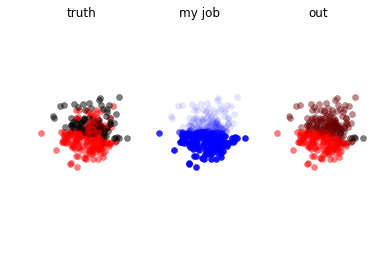

In [40]:
Npats, Nins = 300, 2
X = 2*rng.normal(0,1,size=(Npats,Nins))  # the data points
truth_params = init_params(Nins, 4.)
job, out = calc_outputs(truth_params)
Targ = 1.*(rng.random(out.shape) < out)

do_plots(truth_params)

## Learning, starting from random weights and bias.

In [41]:
def do_one_learning_step(params,X,Targ,rate):  # one step of learning
    grads = classification_gradient(params)
    for s in params.keys():
        change = rate * grads[s]
        params[s] = params[s] + change
        params[s] = params[s] * .999
    params['b'] = params['b'] * .95  # "weight decay" on b encourages mediocrity in NotMyJob
    return (params)

-114.823697291


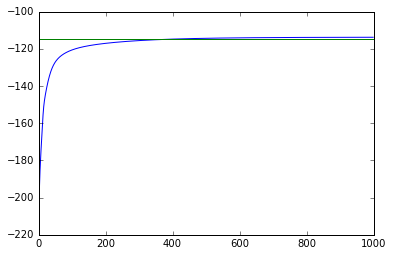

In [48]:
#params = truth_params.copy() #to start from truth - just a test obviously!
params = init_params(Nins, 0.5) # to start from random point in parameter space
L = []
rate = 0.002
steps = 1000.
T = np.arange(steps)
for t in T:
    params = do_one_learning_step(params,X,Targ,rate)
    L.append(classification_loss(params))

pl.plot(T,L)
Lopt = classification_loss(truth_params)
print(Lopt)
pl.plot([0,np.max(T)],[Lopt,Lopt],'-g')

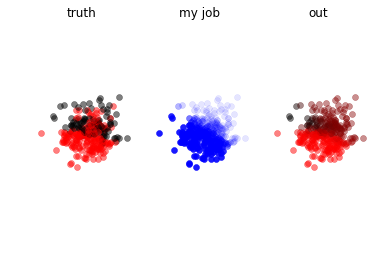

In [49]:
do_plots(params)